# LlamaIndex Agentic Workflows introduction

Welcome to LlamaIndex! In this notebook we'll be walking step-by-step through building agentic workflows.

In LlamaIndex, `Workflow`s are the building blocks of putting together an agent or a multi-agent system. To get you up and running quickly, we have a pre-built Workflow called the `AgentWorkflow` that handles a lot of common agent use cases and allows you to focus on the specifics of your implementation. Later, we'll drop down one level to Workflows themselves and show how to build one from scratch.

To start off, we'll create an AgentWorkflow with a single agent, and use that to cover the basic functionality of the `AgentWorkflow` class.

In [ ]:
%pip install llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.6/250.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.7/298.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.1 MB/s eta 0:00:00


## Getting an LLM

The engine of any agent is the LLM that does the reasoning and text processing. To get started, we'll need access to an LLM.

In this example, we'll be using `OpenAI` as our LLM. LlamaIndex supports more than 30 different LLM providers, including fully local and open-source options. Check out the [examples documentation](https://docs.llamaindex.ai/en/stable/examples/llm/openai/) or [LlamaHub](https://llamahub.ai/?tab=llms) for a list of all supported LLMs and how to install and use them.

First we need an API key:

In [ ]:
from google.colab import userdata
api_key = userdata.get('openai-key')

With our API key in hand, instantiating an LLM is one line:

In [ ]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-4o-mini", api_key=api_key)

A core feature of agents is that they can use tools to find out more about the state of the world, or take action in response to instructions, without you needing to be explicit about how and when they do that.

In this example, we'll give our agent the ability to search the web for information by creating a tool that does that. We'll use a service called Tavily, which is specifically designed to provide this kind of tool to agents. You can get a free API key from [Tavily](https://tavily.com/).

In [ ]:
%pip install tavily-python

In [ ]:
from google.colab import userdata
tavily_api_key = userdata.get('tavily-key')

Tools in LlamaIndex are just regular Python functions, so they can do anything a regular function can.

When creating a tool, its very important to:
- give the tool a distinctive name, and a clear description using docstrings. The LLM uses the name and description to understand what the tool does.
- annotate the types. This helps the LLM understand the expected input and output types.
- use async when possible, since this will make the workflow more efficient.

In [ ]:
from tavily import AsyncTavilyClient

# note the type annotations for the incoming query and the return string
async def search_web(query: str) -> str:
    """Useful for using the web to answer questions."""
    client = AsyncTavilyClient(api_key=tavily_api_key)
    return str(await client.search(query))

With the tool and and LLM defined, we can create an `AgentWorkflow` that uses the tool. AgentWorkflow has a special helper method for creating a single agent from a set of tools, so we'll use that.

We give it a system prompt that defines what the agent does. It's a good idea to tell the agent what kinds of things its tools will allow it to do.

In [ ]:
from llama_index.core.agent.workflow import AgentWorkflow

workflow = AgentWorkflow.from_tools_or_functions(
    [search_web],
    llm=llm,
    system_prompt="You are a helpful assistant that answers questions. If you don't know the answer, you can search the web for information.",
)

## Running the Agent

Now that our agent is created, we can run it! An AgentWorkflow expects to start with a question or prompt in the `user_msg`, which it passes to the agent.

In [ ]:
response = await workflow.run(user_msg="What is the weather in San Francisco?")
print(str(response))

The current weather in San Francisco is as follows:

- **Temperature**: 9.4°C (48.9°F)
- **Condition**: Overcast
- **Wind**: 2.9 mph (4.7 kph) from the south-southwest
- **Humidity**: 80%
- **Visibility**: 16 km (9 miles)
- **Pressure**: 1023 mb (30.21 in)

For more details, you can check the full weather report [here](https://www.weatherapi.com/).


## Maintaining State

By default, the `AgentWorkflow` is stateless between runs. This means that the agent will not have any memory of previous runs.

To maintain state, we need to keep track of the previous state. In LlamaIndex, Workflows have a `Context` that can be used to maintain state within and between runs. Since the `AgentWorkflow` is just a pre-built `Workflow`, we can also use it now.

To maintain state between runs, we'll create a new `Context` called `ctx`. We pass in our `workflow` to properly configure this Context object for the workflow that will use it.

With our configured Context, we can pass it to our first run.

In [ ]:
from llama_index.core.workflow import Context

# configure a context to work with our workflow
ctx = Context(workflow)

response = await workflow.run(
    user_msg="My name is Laurie, nice to meet you!", ctx=ctx # give the configured context to the workflow
)
print(str(response))

Nice to meet you, Laurie! How can I assist you today?


Now we can pass the same context to a second run, and it will remember what happened before:

In [ ]:
# run the workflow again with the same context
response = await workflow.run(user_msg="What is my name?", ctx=ctx)
print(str(response))

Your name is Laurie.


## Maintaining state over longer periods

The context is serializable, so it can be saved to a database, file, etc. and loaded back in later.

The `JsonSerializer` is a simple serializer that uses `json.dumps` and `json.loads` to serialize and deserialize the context.

The `JsonPickleSerializer` is a serializer that uses `pickle` to serialize and deserialize the context. If you have objects in your context that are not serializable, you can use this serializer.

In [ ]:
from llama_index.core.workflow import JsonPickleSerializer, JsonSerializer

# convert our Context to a dictionary object
ctx_dict = ctx.to_dict(serializer=JsonSerializer())

# create a new Context from the dictionary
restored_ctx = Context.from_dict(
    workflow, ctx_dict, serializer=JsonSerializer()
)

In [ ]:
response = await workflow.run(
    user_msg="Do you still remember my name?", ctx=restored_ctx
)
print(str(response))

Yes, I remember your name is Laurie.


## Streaming output and events

In addition to returning a single string when the workflow completes, the `AgentWorkflow` also supports streaming. Since the `AgentWorkflow` is a `Workflow`, it can be streamed like any other `Workflow`. This works by using the handler that is returned from the workflow. The stream returns a variety of event types as the workflow executes, and you can select which ones to handle.

* If you want to stream the LLM output, you can use the `AgentStream` events, which contain a `delta` of the new output each time
* `AgentInput` events will tell you which agent is running (our current workflow just has one agent)
* `AgentOutput` events will tell you what the agents returned, including which tools they called
* `ToolCall` and `ToolCallResults` will track tools as they are called and their outputs

In this example we're only handling the `AgentStream` events, but you can see in the commented-out code how we'd handle the other kinds. You can tell our handling is working because the output will appear in chunks as you run the cell, rather than appearing all at once.

In [ ]:
from llama_index.core.agent.workflow import (
    AgentInput,
    AgentOutput,
    ToolCall,
    ToolCallResult,
    AgentStream,
)

handler = workflow.run(user_msg="What is the weather in Saskatoon?")

async for event in handler.stream_events():
    if isinstance(event, AgentStream):
        print(event.delta, end="", flush=True)
        # print(event.response)  # the current full response
        # print(event.raw)  # the raw llm api response
        # print(event.current_agent_name)  # the current agent name
    # elif isinstance(event, AgentInput):
    #    print(event.input)  # the current input messages
    #    print(event.current_agent_name)  # the current agent name
    # elif isinstance(event, AgentOutput):
    #    print(event.response)  # the current full response
    #    print(event.tool_calls)  # the selected tool calls, if any
    #    print(event.raw)  # the raw llm api response
    # elif isinstance(event, ToolCallResult):
    #    print(event.tool_name)  # the tool name
    #    print(event.tool_kwargs)  # the tool kwargs
    #    print(event.tool_output)  # the tool output
    # elif isinstance(event, ToolCall):
    #     print(event.tool_name)  # the tool name
    #     print(event.tool_kwargs)  # the tool kwargs

The current weather in Saskatoon is as follows:

- **Temperature**: -0.9°C (30.4°F)
- **Condition**: Overcast
- **Wind**: 5.4 mph (8.6 kph) from the SSE
- **Humidity**: 69%
- **Feels Like**: -4.0°C (24.8°F)
- **Visibility**: 24 km (14 miles)

For more details, you can check the full weather report [here](https://www.weatherapi.com/).

Let's see what's happening in more detail by turning on more logging and running it again.

In [ ]:
from llama_index.core.agent.workflow import (
    AgentInput,
    AgentOutput,
    ToolCall,
    ToolCallResult,
    AgentStream,
)

handler = workflow.run(user_msg="What is the weather in Saskatoon?")

async for event in handler.stream_events():
    if isinstance(event, AgentInput):
       print("Agent input: ", event.input)  # the current input messages
       print("Agent name:", event.current_agent_name)  # the current agent name
    elif isinstance(event, AgentOutput):
       print("Agent output: ", event.response)  # the current full response
       print("Tool calls made: ", event.tool_calls)  # the selected tool calls, if any
       print("Raw LLM response: ", event.raw)  # the raw llm api response
    elif isinstance(event, ToolCallResult):
       print("Tool called: ", event.tool_name)  # the tool name
       print("Arguments to the tool: ", event.tool_kwargs)  # the tool kwargs
       print("Tool output: ", event.tool_output)  # the tool output

Agent input:  [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, additional_kwargs={}, blocks=[TextBlock(block_type='text', text="You are a helpful assistant that answers questions. If you don't know the answer, you can search the web for information.")]), ChatMessage(role=<MessageRole.USER: 'user'>, additional_kwargs={}, blocks=[TextBlock(block_type='text', text='What is the weather in Saskatoon?')])]
Agent name: Agent
Agent output:  assistant: None
Tool calls made:  [ToolSelection(tool_id='call_JkXUDizCmpy0bngigJMy00LQ', tool_name='search_web', tool_kwargs={'query': 'current weather in Saskatoon'})]
Raw LLM response:  {'id': 'chatcmpl-Av70m2grvE33Lx1zQoAItx9kl9yKk', 'choices': [{'delta': {'content': None, 'function_call': None, 'refusal': None, 'role': None, 'tool_calls': None}, 'finish_reason': 'tool_calls', 'index': 0, 'logprobs': None}], 'created': 1738175012, 'model': 'gpt-4o-mini-2024-07-18', 'object': 'chat.completion.chunk', 'service_tier': 'default', 'system_fingerprint': 'fp_

You can see the agent accepting input, picking the web search tool, calling it with appropriate arguments, and returning the output.

## Tools and State

Tools can also be defined that have access to the workflow context. This means you can set and retrieve variables from the context and use them in the tool or between tools.

`AgentWorkflow` uses a context variable called `state` that gets passed to every agent. You can rely on information in `state` being available without explicitly having to pass it in.

**Note:** To access the `Context`, the Context parameter should be the first parameter of the tool.

In [ ]:
from llama_index.core.workflow import Context

async def set_name(ctx: Context, name: str) -> str:
    state = await ctx.get("state")
    state["name"] = name
    await ctx.set("state", state)
    return f"Name set to {name}"


workflow = AgentWorkflow.from_tools_or_functions(
    [set_name],
    llm=llm,
    system_prompt="You are a helpful assistant that can set a name.",
    initial_state={"name": "unset"},
)

ctx = Context(workflow)

response = await workflow.run(user_msg="My name is Laurie", ctx=ctx)
print(str(response))

state = await ctx.get("state")
print("Name as stored in state: ",state["name"])

Your name has been set to Laurie.
Name as stored in state:  Laurie


## Human in the Loop

Tools can also be defined that involve a human in the loop. This is useful for tasks that require human input, such as confirming a tool call or providing feedback.

As we'll see in the next section, the way `Workflow`s work under the hood of `AgentWorkflow` is by running `step`s which both emit and receive events. Here's a diagram of the steps (in blue) that makes up an AgentWorkflow and the events (in green) that pass data between them. You'll recognize these events, they're the same ones we were handling in the output stream earlier.

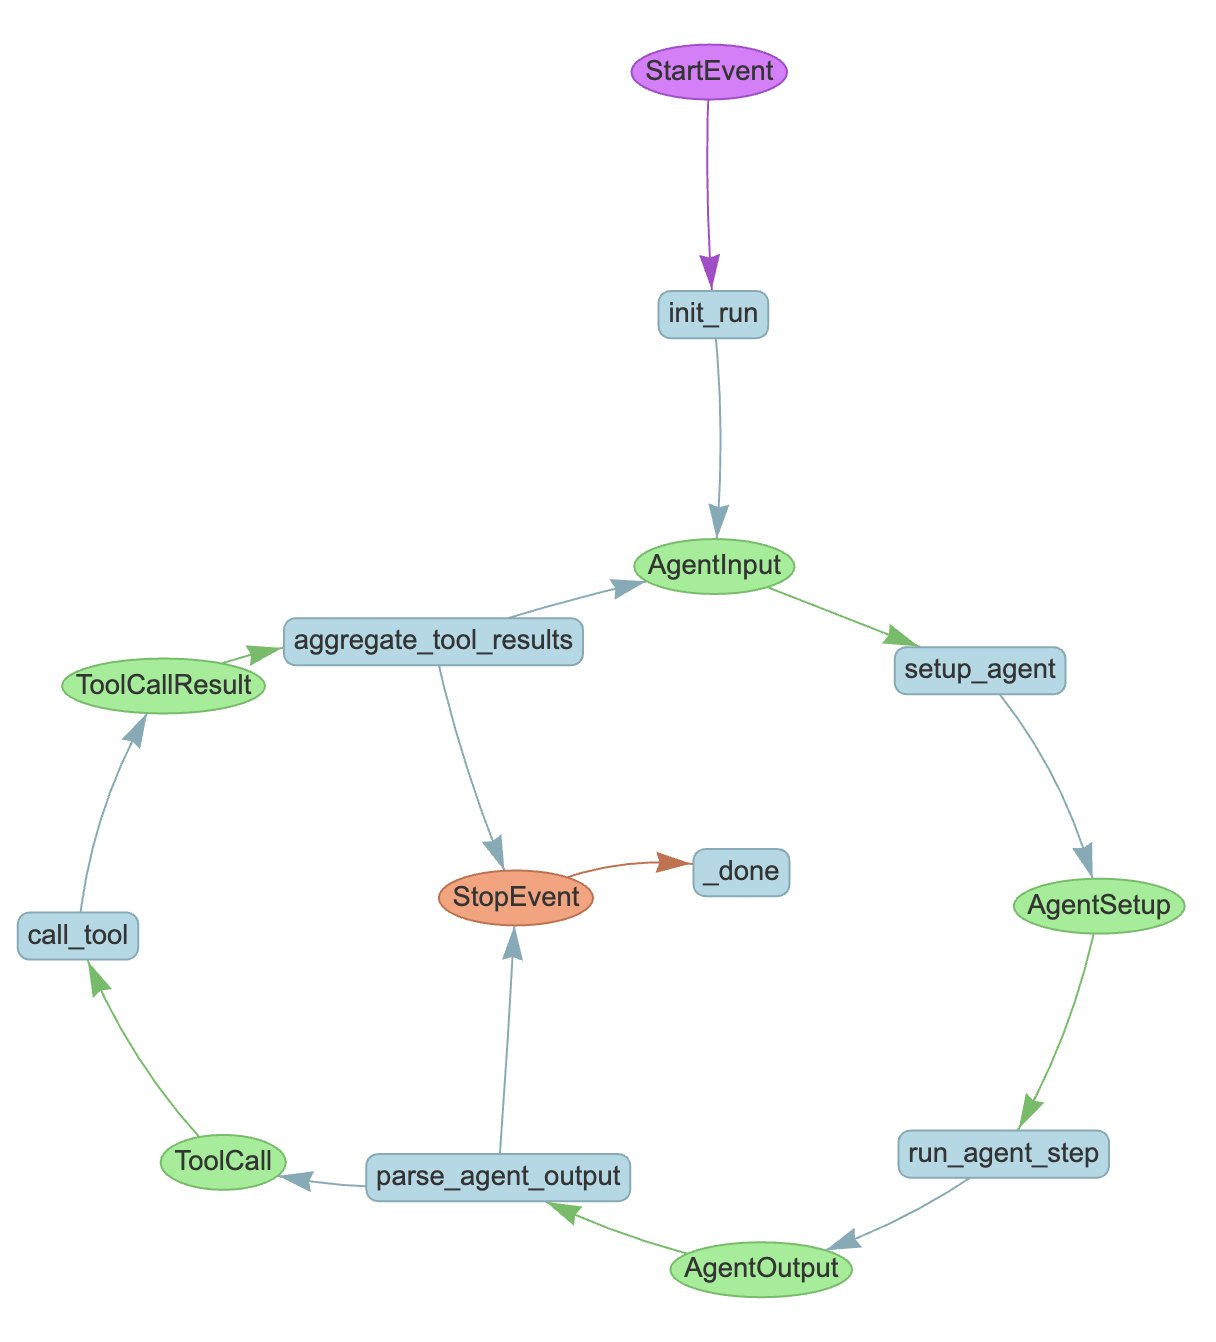

 To get a human in the loop, we'll get our tool to emit an event that isn't received by any other step in the workflow. We'll then tell our tool to wait until it receives a specific "reply" event.

This is a very common pattern for human in the loop, so we have built-in `InputRequiredEvent` and `HumanResponseEvent` events to use for this purpose. If you want to capture different forms of human input, you can subclass these events to match your own preferences.

In [ ]:
from llama_index.core.workflow import (
    Context,
    InputRequiredEvent,
    HumanResponseEvent,
)

# a tool that performs a dangerous task
async def dangerous_task(ctx: Context) -> str:
    """A dangerous task that requires human confirmation."""

    # emit an event to the external stream to be captured
    ctx.write_event_to_stream(
        InputRequiredEvent(
            prefix="Are you sure you want to proceed? ",
            user_name="Laurie",
        )
    )

    # wait until we see a HumanResponseEvent
    response = await ctx.wait_for_event(
        HumanResponseEvent, requirements={"user_name": "Laurie"}
    )

    # act on the input from the event
    if response.response.strip().lower() == "yes":
        return "Dangerous task completed successfully."
    else:
        return "Dangerous task aborted."


workflow = AgentWorkflow.from_tools_or_functions(
    [dangerous_task],
    llm=llm,
    system_prompt="You are a helpful assistant that can perform dangerous tasks.",
)

To capture the event, we use the same streaming interface we used earlier and look for an `InputRequiredEvent`. Then we can use `input` to capture a response from the user, and send it back using the `send_event` method.

In [ ]:
handler = workflow.run(user_msg="I want to proceed with the dangerous task.")

async for event in handler.stream_events():
    # capture InputRequiredEvent
    if isinstance(event, InputRequiredEvent):
        # capture keyboard input
        response = input(event.prefix)
        # send our response back
        handler.ctx.send_event(
            HumanResponseEvent(
                response=response,
                user_name=event.user_name,
            )
        )

response = await handler
print(str(response))

Are you sure you want to proceed? Yes
The dangerous task has been completed successfully. If you need anything else, feel free to ask!


# Congratulations!

You've created your first agent. But `AgentWorkflow`s can do more than single agents; they can also create teams of agents that work together, a very flexible and powerful pattern. Let's see how that works by creating a system that can generate a report on a given topic.

## Multi-agent System Design

Our system will have three agents:

1. A `ResearchAgent` that will search the web for information on the given topic.
2. A `WriteAgent` that will write the report using the information found by the `ResearchAgent`.
3. A `ReviewAgent` that will review the report and provide feedback.

We will use the `AgentWorkflow` class to create a multi-agent system that will execute these agents in order.

There are a lot of ways we could go about building a system to perform this task. In this example, we will use a few tools to help with the research and writing processes.

1. A `web_search` tool to search the web for information on the given topic.
2. A `record_notes` tool which will save research found on the web to the state so that the other tools can use it.
3. A `write_report` tool to write the report using the information found by the `ResearchAgent`
4. A `review_report` tool to review the report and provide feedback.

Utilizing the `Context` class, we can pass state between agents, and each agent will have access to the current state of the system.


We'll use the same Tavily tool we used in our basic agent to help us again.

In [ ]:
async def search_web(query: str) -> str:
    """Useful for using the web to answer questions."""
    client = AsyncTavilyClient(api_key=tavily_api_key)
    return str(await client.search(query))


async def record_notes(ctx: Context, notes: str, notes_title: str) -> str:
    """Useful for recording notes on a given topic."""
    current_state = await ctx.get("state")
    if "research_notes" not in current_state:
        current_state["research_notes"] = {}
    current_state["research_notes"][notes_title] = notes
    await ctx.set("state", current_state)
    return "Notes recorded."


async def write_report(ctx: Context, report_content: str) -> str:
    """Useful for writing a report on a given topic."""
    current_state = await ctx.get("state")
    current_state["report_content"] = report_content
    await ctx.set("state", current_state)
    return "Report written."


async def review_report(ctx: Context, review: str) -> str:
    """Useful for reviewing a report and providing feedback."""
    current_state = await ctx.get("state")
    current_state["review"] = review
    await ctx.set("state", current_state)
    return "Report reviewed."

With our tools defined, we can now create our agents.

If the LLM you are using supports tool calling, you can use the `FunctionAgent` class, which is a little more efficient. Otherwise, you can use the `ReActAgent` class.

Here, the name and description of each agent is used so that the system knows what each agent is responsible for and when to hand off control to the next agent.

Like our single-agent system did before, each agent takes a `system_prompt` that tells it what it should do, and suggests how to work with the other agents.

You can also optionally help your multi-agent system constrain itself by listing which other agents an agent can talk to using `can_handoff_to` (otherwise it will just try to figure this out on its own).

In [ ]:
from llama_index.core.agent.workflow import FunctionAgent, ReActAgent

research_agent = FunctionAgent(
    name="ResearchAgent",
    description="Useful for searching the web for information on a given topic and recording notes on the topic.",
    system_prompt=(
        "You are the ResearchAgent that can search the web for information on a given topic and record notes on the topic. "
        "Once notes are recorded and you are satisfied, you should hand off control to the WriteAgent to write a report on the topic."
    ),
    llm=llm,
    tools=[search_web, record_notes],
    can_handoff_to=["WriteAgent"],
)

write_agent = FunctionAgent(
    name="WriteAgent",
    description="Useful for writing a report on a given topic.",
    system_prompt=(
        "You are the WriteAgent that can write a report on a given topic. "
        "Your report should be in a markdown format. The content should be grounded in the research notes. "
        "Once the report is written, you should get feedback at least once from the ReviewAgent."
    ),
    llm=llm,
    tools=[write_report],
    can_handoff_to=["ReviewAgent", "ResearchAgent"],
)

review_agent = FunctionAgent(
    name="ReviewAgent",
    description="Useful for reviewing a report and providing feedback.",
    system_prompt=(
        "You are the ReviewAgent that can review a report and provide feedback. "
        "Your feedback should either approve the current report or request changes for the WriteAgent to implement."
    ),
    llm=llm,
    tools=[review_report],
    can_handoff_to=["WriteAgent"],
)

## Running the Workflow

With our agents defined, we can create our `AgentWorkflow` and run it. Since this is a multi-agent system, this looks a little different. Instead of using the helper function, we instantiate it directly. It takes:
* an array of agents
* the name of the agent that it should start with (this will receive the initial `user_msg`)
* an `initial_state` which populates the context variable `state` we mentioned earlier

In [ ]:
from llama_index.core.agent.workflow import AgentWorkflow

agent_workflow = AgentWorkflow(
    agents=[research_agent, write_agent, review_agent],
    root_agent=research_agent.name,
    initial_state={
        "research_notes": {},
        "report_content": "Not written yet.",
        "review": "Review required.",
    },
)

As the workflow is running, we will stream the events to get an idea of what is happening under the hood.

In [ ]:
from llama_index.core.agent.workflow import (
    AgentInput,
    AgentOutput,
    ToolCall,
    ToolCallResult,
    AgentStream,
)

handler = agent_workflow.run(
    user_msg="Write me a report on the history of the web. Briefly describe the history of the world wide web, including the development of the internet and the development of the web, including 21st century developments"
)

current_agent = None
current_tool_calls = ""
async for event in handler.stream_events():
    if (
        hasattr(event, "current_agent_name")
        and event.current_agent_name != current_agent
    ):
        current_agent = event.current_agent_name
        print(f"\n{'='*50}")
        print(f"🤖 Agent: {current_agent}")
        print(f"{'='*50}\n")
    elif isinstance(event, AgentOutput):
        if event.response.content:
            print("📤 Output:", event.response.content)
        if event.tool_calls:
            print(
                "🛠️  Planning to use tools:",
                [call.tool_name for call in event.tool_calls],
            )
    elif isinstance(event, ToolCallResult):
        print(f"🔧 Tool Result ({event.tool_name}):")
        print(f"  Arguments: {event.tool_kwargs}")
        print(f"  Output: {event.tool_output}")
    elif isinstance(event, ToolCall):
        print(f"🔨 Calling Tool: {event.tool_name}")
        print(f"  With arguments: {event.tool_kwargs}")


🤖 Agent: ResearchAgent

🛠️  Planning to use tools: ['search_web']
🔨 Calling Tool: search_web
  With arguments: {'query': 'history of the world wide web development internet 21st century'}
🔧 Tool Result (search_web):
  Arguments: {'query': 'history of the world wide web development internet 21st century'}
  Output: {'query': 'history of the world wide web development internet 21st century', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'History of the World Wide Web', 'url': 'https://worldofhistorycheatsheet.com/history-of-the-world-wide-web/', 'content': 'History of the World Wide Web | World of History History of the World Wide Web NSFNET and the Spread of the Web: In the early 1990s, the National Science Foundation Network (NSFNET) in the United States expanded access to the internet for academic and research institutions. The Dot-Com Boom Begins: By 1995, the World Wide Web had become a household term, and the first wave of internet companies, or 

Now we can see the final output:

In [ ]:
state = await handler.ctx.get("state")
print(state["report_content"])

# The History of the World Wide Web

## Introduction
The World Wide Web (WWW) has transformed the way we access information, communicate, and conduct business. Its development is closely tied to the evolution of the internet itself, which has undergone significant changes since its inception.

## Development of the Internet
The origins of the internet can be traced back to ARPANET, a project initiated in the late 1960s by the U.S. Department of Defense. ARPANET was designed to facilitate communication among researchers and allowed for the sharing of information across different computers. Over the years, this network evolved, leading to the establishment of protocols that enabled different networks to connect, ultimately forming what we now know as the internet.

## Birth of the World Wide Web
In 1989, British computer scientist Tim Berners-Lee proposed a global hypertext project while working at CERN. By December 1990, he and his team had developed the essential tools for the web, inc

In [ ]:
print(state["review"])

The report on the history of the web is well-structured and covers the essential aspects of the topic, including the development of the internet, the birth of the World Wide Web, the dot-com boom, Web 2.0, and 21st-century developments. It provides a clear timeline and context for each phase of development. Overall, the report is informative and concise, making it suitable for readers seeking to understand the evolution of the web. I approve this report.


## Congratulations again!

You've successfully put together a multi-agent system using `AgentWorkflow`. `AgentWorkflow` is designed to be a simple jumping-off point for putting together a team of agents to solve a problem. But LlamaIndex can do even more!

## Building agentic workflows from scratch

As mentioned, `AgentWorkflow` is a pre-built `Workflow`, so you've already encountered many of the concepts you need to build a workflow from scratch.

You can easily build your own workflows directly to create multi-agent systems that are customized to your needs. There's a number of reasons you might want to branch out from AgentWorkflow to rolling your own workflow:

* **Fine-grained flow control**: Workflows allow looping, branching, parallel calls and map-reduce behavior. Workflows allow you to precisely specify how data gets passed around your system.

* **Reflection**: A powerful technique for agents is their ability to examine their own output and decide whether it's sufficient, or if they need to try again. Using looping, you can implement this pattern.

* **Structured inputs and outputs**: If you want your inputs and outputs to be richer than simple strings, or to kick off with more than just a `user_msg`, workflows allow you to do that.

* **Multimodality**: LlamaIndex can handle more than just text! You can handle images, audio and video as well.

* **Query planning**: a custom workflow can execute complex planning of how to run based on its inputs, rather than immediately jumping into a team.

## Creating a new workflow

Under the hood, Workflows are regular Python classes. They are defined as a series of `steps`, each of which receives certain classes of events and emits certain classes of events.

Here's the most basic form of a workflow, with a single step:

In [ ]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
)

class MyWorkflow(Workflow):
    @step
    async def my_step(self, ev: StartEvent) -> StopEvent:
        # do something here
        return StopEvent(result="Hello, world!")

This new `MyWorkflow` class:
* Uses the `@step` decorator to declare a function to be a step
* Has a single step called `my_step` which accepts a `StartEvent`. `StartEvent` is a special event which is always generated when a workflow first runs.
* `my_step` returns a `StopEvent`, which is another special event. When a `StopEvent` is emitted the workflow returns it and stops running.

You instantiate it and run it just like you ran the the `AgentWorkflow`:

In [ ]:
workflow = MyWorkflow(timeout=10, verbose=False)
result = await workflow.run()
print(result)

Hello, world!


## Type annotations for steps

The type annotations (e.g. `ev: StartEvent` and `-> StopEvent`) are essential to the way Workflows work. The expected types determine what event types will trigger a step. Tools like the visualizer (see later) also rely on these annotations to determine what types are generated and therefore where control flow goes next.

## Aside: running a workflow in regular python

Workflows are async by default, so you use `await` to get the result of the `run` command. This will work fine in a notebook environment; in a vanilla python script you will need to import `asyncio` and wrap your code in an async function, like this:

```
async def main():
    w = MyWorkflow(timeout=10, verbose=False)
    result = await w.run()
    print(result)


if __name__ == "__main__":
    import asyncio
    asyncio.run(main())
```

Since we're in a notebook right now, we won't execute the above code as it won't work!

## Visualizing a workflow

A great feature of workflows is the built-in visualizer, which we will install now:


In [ ]:
!pip install llama-index-utils-workflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.6 MB/s eta 0:00:00


Let's visualize the simple workflow we just created:

In [ ]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(MyWorkflow, filename="basic_workflow.html")

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StopEvent'>
basic_workflow.html


This creates a file called `basic_workflow.html` in the notebook's file system. You can open up the file pane and download the file, then open it in your browser. You'll see something like this:

<img width="500" src="https://seldo.com/uploads/2025/basic_flow.png">

Of course, a flow with a single step is not very useful! Let's define a multi-step workflow.

## Custom Events

Multiple steps are created by defining custom events that can be emitted by steps and trigger other steps. Let's define a simple 3-step workflow by defining two custom events, `FirstEvent` and `SecondEvent`. These classes can have any names and properties, but must inherit from `Event`:


In [ ]:
from llama_index.core.workflow import Event

class FirstEvent(Event):
    first_output: str

class SecondEvent(Event):
    second_output: str

## Defining the workflow

Now we define the workflow itself. We do this by defining the input and output types on each step.

* `step_one` takes a `StartEvent` and returns a `FirstEvent`
* `step_two` takes a `FirstEvent` and returns a `SecondEvent`
* `step_three` takes a `SecondEvent` and returns a `StopEvent`

In [ ]:
class MyWorkflow(Workflow):
    @step
    async def step_one(self, ev: StartEvent) -> FirstEvent:
        print(ev.first_input)
        return FirstEvent(first_output="First step complete.")

    @step
    async def step_two(self, ev: FirstEvent) -> SecondEvent:
        print(ev.first_output)
        return SecondEvent(second_output="Second step complete.")

    @step
    async def step_three(self, ev: SecondEvent) -> StopEvent:
        print(ev.second_output)
        return StopEvent(result="Workflow complete.")


w = MyWorkflow(timeout=10, verbose=False)
result = await w.run(first_input="Start the workflow.")
print(result)

Start the workflow.
First step complete.
Second step complete.
Workflow complete.


If we run this through the visualizer, we'll get something like this:

<img width="500" src="https://seldo.com/uploads/2025/multi_step.png">

# Branches and loops

However, there's not much point to a workflow if it just runs straight through! A key feature of Workflows is their enablement of branching and looping logic, more simply and flexibly than graph-based approaches. To enable looping, we'll create a new `LoopEvent`

In [ ]:
class LoopEvent(Event):
    loop_output: str

Now we'll edit our `step_one` to make a random decision about whether to execute serially or loop back:

In [ ]:
import random

class MyWorkflow(Workflow):

    @step
    async def step_one(self, ev: StartEvent | LoopEvent) -> FirstEvent | LoopEvent:
        if random.randint(0, 1) == 0:
            print("Bad thing happened")
            return LoopEvent(loop_output="Back to step one.")
        else:
            print("Good thing happened")
            return FirstEvent(first_output="First step complete.")

    @step
    async def step_two(self, ev: FirstEvent) -> SecondEvent:
        print(ev.first_output)
        return SecondEvent(second_output="Second step complete.")

    @step
    async def step_three(self, ev: SecondEvent) -> StopEvent:
        print(ev.second_output)
        return StopEvent(result="Workflow complete.")


w = MyWorkflow(timeout=10, verbose=False)
result = await w.run(first_input="Start the workflow.")
print(result)

Bad thing happened
Bad thing happened
Good thing happened
First step complete.
Second step complete.
Workflow complete.


Note the new type annotations on `step_one`: we now accept either a `StartEvent` or a `LoopEvent` to trigger the step, and we also emit either a `FirstEvent` or a `LoopEvent`.

Our new, looping workflow visualizes like this:

<img width="500" src="https://seldo.com/uploads/2025/loop.png">

## Branching

The same constructs that allow us to loop allow us to create branches. Here's a workflow that executes two different branches depending on an early decision:

In [ ]:
class BranchA1Event(Event):
    payload: str


class BranchA2Event(Event):
    payload: str


class BranchB1Event(Event):
    payload: str


class BranchB2Event(Event):
    payload: str


class BranchWorkflow(Workflow):
    @step
    async def start(self, ev: StartEvent) -> BranchA1Event | BranchB1Event:
        if random.randint(0, 1) == 0:
            print("Go to branch A")
            return BranchA1Event(payload="Branch A")
        else:
            print("Go to branch B")
            return BranchB1Event(payload="Branch B")

    @step
    async def step_a1(self, ev: BranchA1Event) -> BranchA2Event:
        print(ev.payload)
        return BranchA2Event(payload=ev.payload)

    @step
    async def step_b1(self, ev: BranchB1Event) -> BranchB2Event:
        print(ev.payload)
        return BranchB2Event(payload=ev.payload)

    @step
    async def step_a2(self, ev: BranchA2Event) -> StopEvent:
        print(ev.payload)
        return StopEvent(result="Branch A complete.")

    @step
    async def step_b2(self, ev: BranchB2Event) -> StopEvent:
        print(ev.payload)
        return StopEvent(result="Branch B complete.")

It visualizes like this:

<img width="700" src="https://seldo.com/uploads/2025/branching.png">

## Concurrent execution

The final form of flow control you can implement in workflows is concurrent execution. This allows you to efficiently run long-running tasks in parallel, and gather them together when they are needed. This can also let you perform map-reduce style tasks. Let's see how this is done.

To do this, we'll be using the `Context` object that we already encountered when working with `AgentWorkflow`. The `Context` is available to every step in a workflow: to access it, declare it as an argument to your step and it will be automatically populated.

In this example, we use a new method, `Context.send_event` rather than returning an event. This allows us to emit multiple events in parallel rather than picking just one as previously.

In [ ]:
import asyncio

class StepTwoEvent(Event):
    query: str

class ParallelFlow(Workflow):
    @step
    async def start(self, ctx: Context, ev: StartEvent) -> StepTwoEvent:
        ctx.send_event(StepTwoEvent(query="Query 1"))
        ctx.send_event(StepTwoEvent(query="Query 2"))
        ctx.send_event(StepTwoEvent(query="Query 3"))

    @step(num_workers=4)
    async def step_two(self, ctx: Context, ev: StepTwoEvent) -> StopEvent:
        print("Running slow query ", ev.query)
        await asyncio.sleep(random.randint(1, 5))

        return StopEvent(result=ev.query)

In [ ]:
w = ParallelFlow(timeout=10, verbose=False)
result = await w.run(message="Start the workflow.")
print(result)

Running slow query  Query 1
Running slow query  Query 2
Running slow query  Query 3
Query 2


As you can see, it executes all 3 queries. The first one to complete emits a StopEvent, at which point the workflow halts without waiting for the other 2 events.

## Collecting events

But what if we do want the output of all 3 events? Another method, `Context.collect_events`, exists for that purpose:

In [ ]:
class StepThreeEvent(Event):
    result: str

class ConcurrentFlow(Workflow):
    @step
    async def start(self, ctx: Context, ev: StartEvent) -> StepTwoEvent:
        ctx.send_event(StepTwoEvent(query="Query 1"))
        ctx.send_event(StepTwoEvent(query="Query 2"))
        ctx.send_event(StepTwoEvent(query="Query 3"))

    @step(num_workers=4)
    async def step_two(self, ctx: Context, ev: StepTwoEvent) -> StepThreeEvent:
        print("Running query ", ev.query)
        await asyncio.sleep(random.randint(1, 5))
        return StepThreeEvent(result=ev.query)

    @step
    async def step_three(self, ctx: Context, ev: StepThreeEvent) -> StopEvent:
        # wait until we receive 3 events
        result = ctx.collect_events(ev, [StepThreeEvent] * 3)
        if result is None:
            print("Not all events received yet.")
            return None

        # do something with all 3 results together
        print(result)
        return StopEvent(result="Done")

In [ ]:
w = ConcurrentFlow(timeout=10, verbose=False)
result = await w.run(message="Start the workflow.")
print(result)

Running query  Query 1
Running query  Query 2
Running query  Query 3
Not all events received yet.
Not all events received yet.
[StepThreeEvent(result='Query 1'), StepThreeEvent(result='Query 2'), StepThreeEvent(result='Query 3')]
Done


In the above example, we emit three `StepTwoEvent`s which trigger `step_two`, each execution of which eventually emits a `StepThreeEvent`.

`step_three` gets triggered whenever a `StepThreeEvent` fires. What `collect_events` does is store the events in the context until it has collected the number and type of events specified in its second argument. In this case, we've told it to wait for 3 events.

If an event fires and `collect_events` hasn't yet seen the right number of events, it returns `None`, so we tell `step_three` to do nothing in that case. When `collect_events` receives the right number of events it returns them as an array, which you can see us printing in the final output.

To implement a map-reduce pattern, you would split your task up into as many steps as necessary, and use `Context` to store that number with `ctx.set("num_events", some_number)`. Then in `step_three` you would wait for the number stored in the context using `await ctx.get("num_events")`. So you don't need to know in advance exactly how many concurrent steps you're taking.

## Collecting different event types

We don't just have to wait for multiple events of the same kind. In this example, we'll emit 3 totally different events and collect them at the end.

In [ ]:
class StepAEvent(Event):
    query: str

class StepACompleteEvent(Event):
    result: str

class StepBEvent(Event):
    query: str

class StepBCompleteEvent(Event):
    result: str

class StepCEvent(Event):
    query: str

class StepCCompleteEvent(Event):
    result: str

class ConcurrentFlow(Workflow):
    @step
    async def start(
        self, ctx: Context, ev: StartEvent
    ) -> StepAEvent | StepBEvent | StepCEvent:
        ctx.send_event(StepAEvent(query="Query 1"))
        ctx.send_event(StepBEvent(query="Query 2"))
        ctx.send_event(StepCEvent(query="Query 3"))

    @step
    async def step_a(self, ctx: Context, ev: StepAEvent) -> StepACompleteEvent:
        print("Doing something A-ish")
        return StepACompleteEvent(result=ev.query)

    @step
    async def step_b(self, ctx: Context, ev: StepBEvent) -> StepBCompleteEvent:
        print("Doing something B-ish")
        return StepBCompleteEvent(result=ev.query)

    @step
    async def step_c(self, ctx: Context, ev: StepCEvent) -> StepCCompleteEvent:
        print("Doing something C-ish")
        return StepCCompleteEvent(result=ev.query)

    @step
    async def step_three(
        self,
        ctx: Context,
        ev: StepACompleteEvent | StepBCompleteEvent | StepCCompleteEvent,
    ) -> StopEvent:
        print("Received event ", ev.result)

        # wait until we receive 3 events
        events = ctx.collect_events(
            ev,
            [StepCCompleteEvent, StepACompleteEvent, StepBCompleteEvent],
        )
        if (events is None):
            return None

        # do something with all 3 results together
        print("All events received: ", events)
        return StopEvent(result="Done")

When we run, it will do all three things and wait for them in `step_three`.

In [ ]:
w = ConcurrentFlow(timeout=10, verbose=False)
result = await w.run(message="Start the workflow.")
print(result)

Doing something A-ish
Doing something B-ish
Doing something C-ish
Received event  Query 1
Received event  Query 2
Received event  Query 3
All events received:  [StepCCompleteEvent(result='Query 3'), StepACompleteEvent(result='Query 1'), StepBCompleteEvent(result='Query 2')]
Done


Note that the order of the events is significant: `collect_events` was told to expect Step C, then A, then B, and that's the order they are in the return array.

These changes have a pretty pleasing visualization:

<img width="700" src="https://seldo.com/uploads/2025/different_events.png">

## Streaming

We already saw `AgentWorkflow` emit a stream of events that we could handle and filter when we run the event. Let's see how those get emitted in this example, using `Context.write_event_to_stream`:

In [ ]:
class FirstEvent(Event):
    first_output: str

class SecondEvent(Event):
    second_output: str
    response: str

class TextEvent(Event):
    delta: str

class ProgressEvent(Event):
    msg: str

class MyWorkflow(Workflow):
    @step
    async def step_one(self, ctx: Context, ev: StartEvent) -> FirstEvent:
        ctx.write_event_to_stream(ProgressEvent(msg="Step one is happening"))
        return FirstEvent(first_output="First step complete.")

    @step
    async def step_two(self, ctx: Context, ev: FirstEvent) -> SecondEvent:
        llm = OpenAI(model="gpt-4o-mini", api_key=api_key) # the OpenAI key we set up at the beginning
        generator = await llm.astream_complete(
            "Please give me the first 50 words of Moby Dick, a book in the public domain."
        )
        async for response in generator:
            # Allow the workflow to stream this piece of response
            ctx.write_event_to_stream(TextEvent(delta=response.delta))
        return SecondEvent(
            second_output="Second step complete, full response attached",
            response=str(response),
        )

    @step
    async def step_three(self, ctx: Context, ev: SecondEvent) -> StopEvent:
        ctx.write_event_to_stream(ProgressEvent(msg="Step three is happening"))
        return StopEvent(result="Workflow complete.")

We handle this output exactly the same way we did for `AgentWorkflow`:

In [ ]:
workflow = MyWorkflow(timeout=30, verbose=False)
handler = workflow.run(first_input="Start the workflow.")

async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print(ev.msg)
    if isinstance(ev, TextEvent):
        print(ev.delta, end="")

final_result = await handler
print("Final result = ", final_result)

Step one is happening
Sure! The first 50 words of "Moby Dick" by Herman Melville are:

"Call me Ishmael. Some years ago—never mind how long precisely—I had little or no money in my purse, and nothing particular to interest me on shore. So, whenever I find myself growing grim about the mouth; whenever it is a damp, drizzly November in my soul;"Step three is happening
Final result =  Workflow complete.


## Putting together a multi-agent system

Now we've seen all the ways workflows can work, let's construct our own multi-agent system!

We'll have to create new agents, since the FunctionCallingAgents we made earlier are specifically adapted to run inside of `AgentWorkflow`. Making a generic function calling agent is very similar:

In [ ]:
from llama_index.core.agent import FunctionCallingAgent as GenericFunctionCallingAgent
from llama_index.core.tools import FunctionTool

# convert our web search functions into a tool, the generic function calling agent doesn't do this automatically (yet)
search_web_tool = FunctionTool.from_defaults(fn=search_web)

research_agent = GenericFunctionCallingAgent.from_tools(
    tools=[search_web_tool],
    llm=llm,
    verbose=False,
    allow_parallel_tool_calls=False,
    system_prompt="You are an agent that does research by searching the web and then records the results of your research."
)
write_agent = GenericFunctionCallingAgent.from_tools(
    tools=[],
    llm=llm,
    verbose=False,
    allow_parallel_tool_calls=False,
    system_prompt="You are an agent that writes a report based on the results of research by another agent."
)
review_agent = GenericFunctionCallingAgent.from_tools(
    tools=[],
    llm=llm,
    verbose=False,
    allow_parallel_tool_calls=False,
    system_prompt="You are an agent that reviews a report written by a different agent."
)

We'll create a simple linear flow to start with:

In [ ]:
class ResearchEvent(Event):
    prompt: str

class WriteEvent(Event):
    research: str

class ReviewEvent(Event):
    report: str

class ReviewResults(Event):
    review: str

class SimpleMultiAgentFlow(Workflow):

    @step
    async def setup(self, ev: StartEvent) -> ResearchEvent:
        self.research_agent = ev.research_agent
        self.write_agent = ev.write_agent
        self.review_agent = ev.review_agent
        return ResearchEvent(prompt=ev.prompt)

    @step
    async def research(self, ctx: Context, ev: ResearchEvent) -> WriteEvent:

        await ctx.set("prompt", ev.prompt)
        result = self.research_agent.chat(f"Do some research that another agent will use to write a report about this topic: <topic>{ev.prompt}</topic>. Just include the facts without making it into a full report.")

        return WriteEvent(research=str(result))

    @step
    async def write(self, ctx: Context, ev: WriteEvent) -> ReviewEvent:
        result = self.write_agent.chat(f"Write a report based on this research: <research>{ev.research}</research> and this topic: <topic>{await ctx.get('prompt')}</topic>")

        return ReviewEvent(report=str(result))

    @step
    async def review(self, ctx: Context, ev: ReviewEvent) -> StopEvent:
        result = self.review_agent.chat(f"Review this report: <report>{ev.report}</report>")

        ctx.write_event_to_stream(ReviewResults(review=str(result)))

        return StopEvent(result=ev.report)

Running it gets us a report and a review of that report:

In [ ]:
import nest_asyncio
nest_asyncio.apply()

workflow = SimpleMultiAgentFlow(timeout=30, verbose=True)
handler = workflow.run(
    prompt="History of San Francisco",
    research_agent=research_agent,
    write_agent=write_agent,
    review_agent=review_agent
)

async for ev in handler.stream_events():
    if isinstance(ev, ReviewResults):
        print("==== The review ====")
        print(ev.review)

final_result = await handler
print("==== The report ====")
print(final_result)

Running step setup
Step setup produced event ResearchEvent
Running step research
Step research produced event WriteEvent
Running step write
Step write produced event ReviewEvent
Running step review
Step review produced event StopEvent
==== The review ====
### Review of the Report on the History of San Francisco

#### Overall Impression
The report provides a comprehensive overview of San Francisco's history, effectively capturing key events and developments that have shaped the city. It is well-structured, with clear headings that guide the reader through different historical periods. The language is accessible, making it suitable for a broad audience.

#### Strengths
1. **Chronological Structure**: The report follows a logical chronological order, making it easy for readers to understand the progression of San Francisco's history.
2. **Key Events Highlighted**: Important milestones, such as the establishment of Mission Dolores, the Gold Rush, the Panama-Pacific International Exposition

## Adding Reflection

But we mentioned reflection as an extra feature we can add because we have fine-grained control. Let's add that!

We need to make several changes:
* In `research` we'll store the research into the context, since we might need to use it multiple times
* We'll tell `write` that it can be triggered by a `RewriteEvent` in addition to a `WriteEvent`
* If it's a `RewriteEvent` we'll add the review as feedback to the prompt
* `review` will be changed to optionally emit a `RewriteEvent`
* We'll get the LLM to decide if the review returned by the agent is a "bad" or "good" review

In [ ]:
class RewriteEvent(Event):
    review: str

# Our WriteEvent doesn't need research attached any more
class WriteEvent(Event):
    pass

class MultiAgentFlowWithReflection(Workflow):

    @step
    async def setup(self, ev: StartEvent) -> ResearchEvent:
        self.research_agent = ev.research_agent
        self.write_agent = ev.write_agent
        self.review_agent = ev.review_agent
        return ResearchEvent(prompt=ev.prompt)

    @step
    async def research(self, ctx: Context, ev: ResearchEvent) -> WriteEvent:

        await ctx.set("prompt", ev.prompt)
        result = self.research_agent.chat(f"Do some research that another agent will use to write a report about this topic: <topic>{ev.prompt}</topic>. Just include the facts without making it into a full report.")

        # store the research in the context for multiple uses
        await ctx.set("research", str(result))

        return WriteEvent()

    @step
    async def write(self, ctx: Context, ev: WriteEvent | RewriteEvent ) -> ReviewEvent:

        prompt = f"Write a report based on this research: <research>{await ctx.get('research')}</research> and this topic: <topic>{await ctx.get('prompt')}</topic> "

        # detect RewriteEvents and modify the prompt
        if isinstance(ev, RewriteEvent):
            print("Doing a rewrite!")
            prompt += f"This report has reviewed and the reviewer had this feedback, which you should take into account: <review>{ev.review}</review>"

        result = self.write_agent.chat(prompt)

        return ReviewEvent(report=str(result))

    @step
    async def review(self, ctx: Context, ev: ReviewEvent) -> StopEvent | RewriteEvent:
        result = self.review_agent.chat(f"Review this report: {ev.report}")

        # get the LLM to self-reflect
        try_again = llm.complete(f"This is a review of a report written by an agent. If you think this review is bad enough that the agent should try again, respond with just the word RETRY. If the review is good, reply with just the word CONTINUE. Here's the review: <review>{str(result)}</review>")

        if try_again.text == "RETRY":
            print("Reviewer said try again")
            return RewriteEvent(review=str(result))
        else:
            print("Reviewer thought it was good!")
            return StopEvent(result=ev.report)

In [ ]:
workflow = MultiAgentFlowWithReflection(timeout=30, verbose=True)
handler = workflow.run(
    prompt="History of San Francisco",
    research_agent=research_agent,
    write_agent=write_agent,
    review_agent=review_agent
)

final_result = await handler
print("==== The report ====")
print(final_result)

Running step setup
Step setup produced event ResearchEvent
Running step research
Step research produced event WriteEvent
Running step write
Step write produced event ReviewEvent
Running step review
Reviewer thought it was good!
Step review produced event StopEvent
==== The report ====
# Report on the History of San Francisco

## Introduction
San Francisco, a city known for its vibrant culture and historical significance, has a rich history that reflects the diverse influences and transformations it has undergone over the centuries. This report highlights key events and developments that have shaped San Francisco from its indigenous roots to its current status as a technological powerhouse.

## Indigenous Inhabitants
The history of San Francisco begins with the Ohlone people, who inhabited the San Francisco Bay Area for thousands of years before European contact. Their deep connection to the land and rich cultural traditions laid the groundwork for the region's identity.

## Spanish Col

In this run, the reviewer thought the report was good! If we visualize the flow however we can see the reflection loop:

<img width="500" src="https://seldo.com/uploads/2025/Screenshot%202025-01-25%20at%204.04.52%E2%80%AFPM.png">

## Congratulations yet again!

You've come a long way in this notebook -- from a single agent flow, to
a multi-agent `AgentWorkflow` all the way through to full `Workflows`, with fine-grained flow control and self-reflection. What will you build your multi-agent system to do?